In [9]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

from data_processing.timeseries_analytical_tools import (test_stationarity,
                                                        seasonal_charts,
                                                        find_optimal_pdq,
                                                        plot_act_pacf,
                                                        sarimax_plot,
                                                        plot_line_price)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load futures data for corn and soybeans.
corn_monthly = pd.read_pickle('clean_data/CornCBOT_monthly.pkl')
soybeans_monthly = pd.read_pickle('clean_data/SoybeansCBOT_monthly.pkl')

### Full raw dataset for Corn.

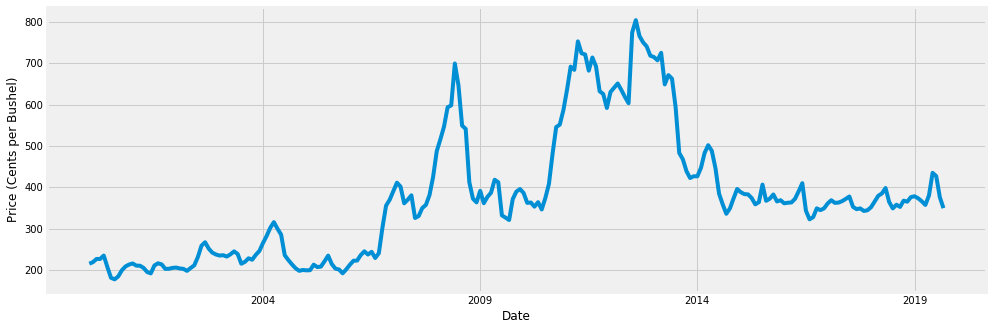

In [4]:
plot_line_price(corn_monthly, 'visuals/corn_20year_close.png')

### Check 12 month seasonality for Corn.
Seasonal decomposition chart indicates that there is a yearly pattern.

<Figure size 432x288 with 0 Axes>

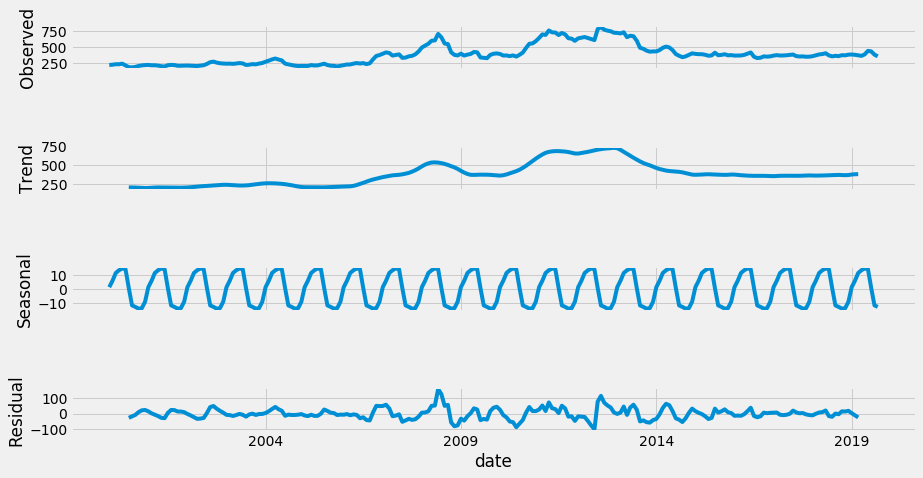

In [14]:
seasonal_charts(corn_monthly, 12);

### Check stationary assumption

##### Raw data test does not pass stationarity test.

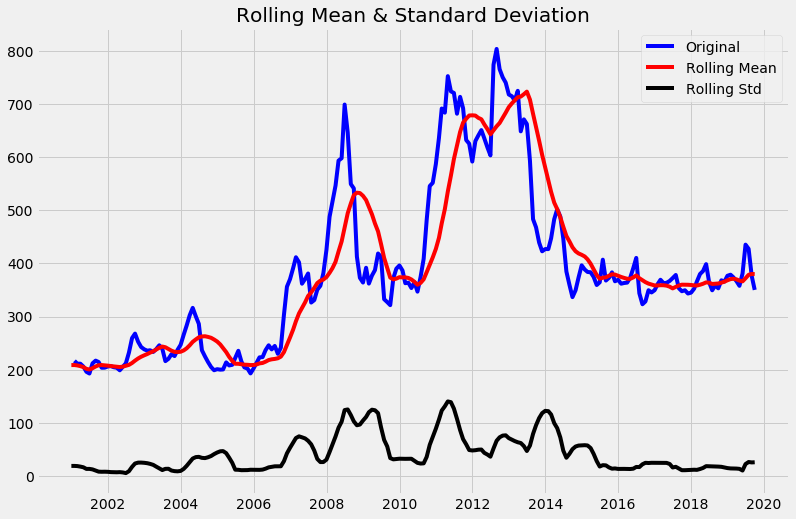

Results of Dickey-Fuller Test:
Test Statistic                  -2.070567
p-value                          0.256513
#Lags Used                       1.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [15]:
test_stationarity(corn_monthly, 12)

##### First level difference passes Dickey-Fuller test.

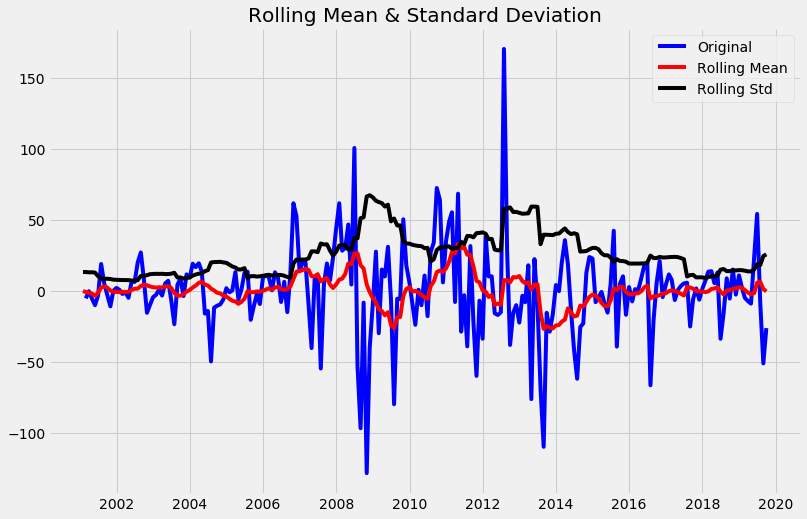

Results of Dickey-Fuller Test:
Test Statistic                -1.178528e+01
p-value                        1.012287e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


In [16]:
test_stationarity(corn_monthly.diff(1).dropna(), 12)

##### Seasonal Difference also passes Dickey-Fuller test.

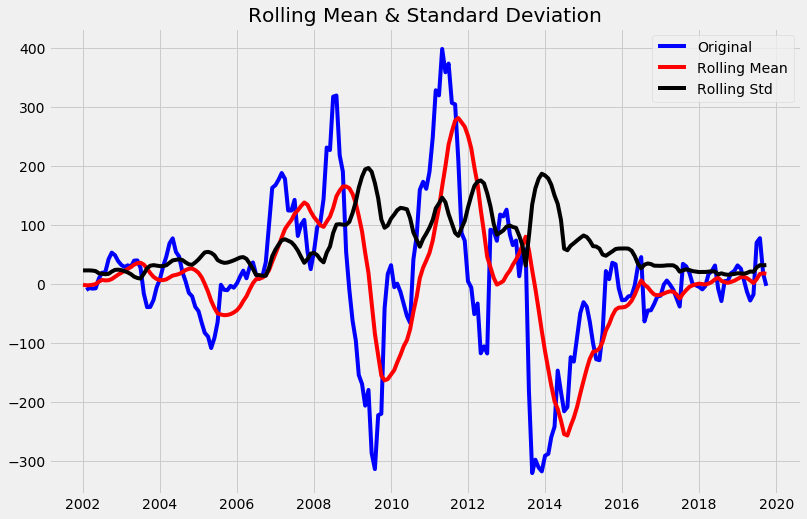

Results of Dickey-Fuller Test:
Test Statistic                  -2.893718
p-value                          0.046083
#Lags Used                      15.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


In [17]:
test_stationarity(corn_monthly.diff(12).dropna(), 12)

### Test model for optimal PDQ values

##### First difference ACF and PACF terms show significant correlation drops after 1 month lag.  
##### This indicates that P and Q terms should be kept at 0 or 1.

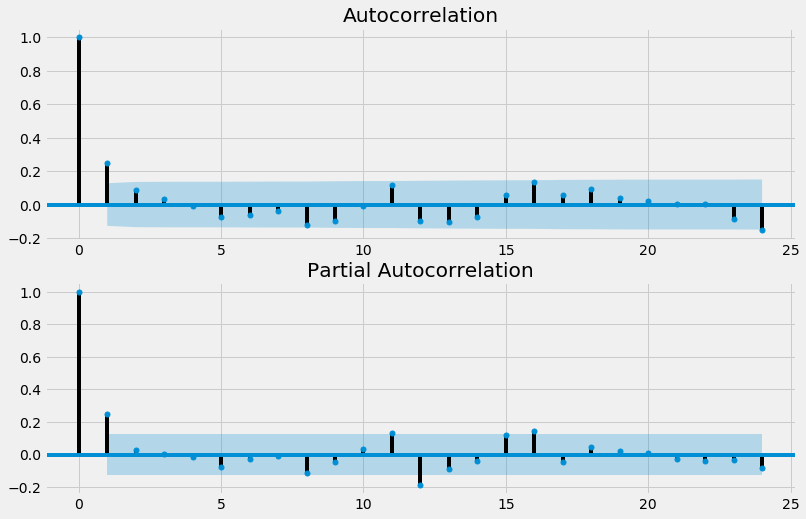

In [18]:
plot_act_pacf(corn_monthly, 1)

### Test model for seasonal PDQ values.

##### Seasonal difference (12 months) 
  - PACF shows significant correlation ends after 1 month lag.  
  - This indicates that P term should be kept at 0 or 1.

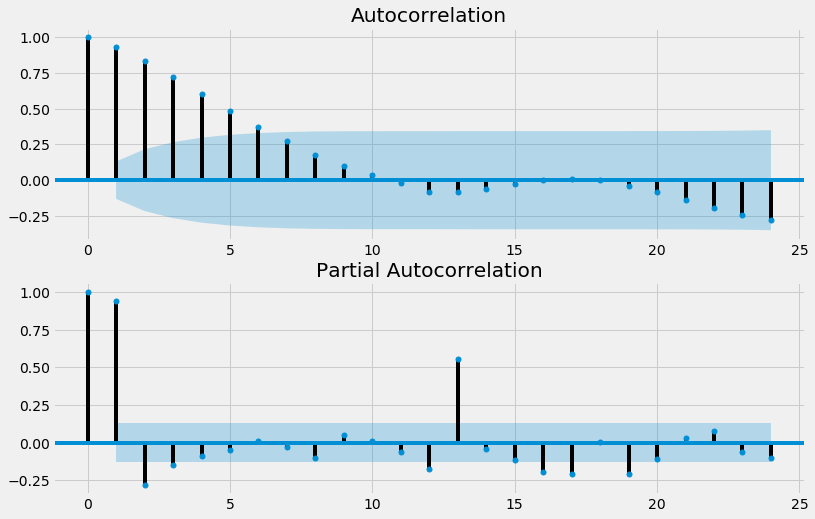

In [19]:
plot_act_pacf(corn_monthly, 12)

### Grid search to confirm optimal PDQ.

##### All combinations of valid PDQ terms, as indicated by ACF and PACF, were tested through a grid search.  Resulting models were compared using AIC.
  - Results indicate these are the optimal terms: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:273

In [68]:
pdq_results = find_optimal_pdq(corn_monthly, 12, '2014-1-1')

100%|██████████| 8/8 [00:13<00:00,  1.65s/it]

Min AIC:
                                                  key         aic  \
62  ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:273.41862...  273.418624   
46  ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:274.53613...  274.536137   
54  ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:276.55091...  276.550912   
38  ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:280.05198...  280.051987   
30  ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:281.36750...  281.367504   

             mse  
62   8687.716161  
46  12565.884518  
54   6715.355604  
38   9744.772130  
30   8560.533883  
Min MSE:
                                                  key         aic          mse
22  ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:282.77403...  282.774037  6696.103624
54  ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:276.55091...  276.550912  6715.355604
30  ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:281.36750...  281.367504  8560.533883
62  ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:273.41862...  273.418624  8687.716161
38  ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:280.05198...  280

### Run model and plot predictions for previous 5 years.
  - Predicitons confirm seasonal pattern
  - Shaded region indicates 80% confidence interval 

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                   57
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -137.684
Date:                            Wed, 11 Sep 2019   AIC                            281.368
Time:                                    09:57:25   BIC                            285.765
Sample:                                01-31-2014   HQIC                           282.825
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6290      0.145     -4.327      0.000      -0.914      -0.344
ar.S.L12      -0.4991      0.090   

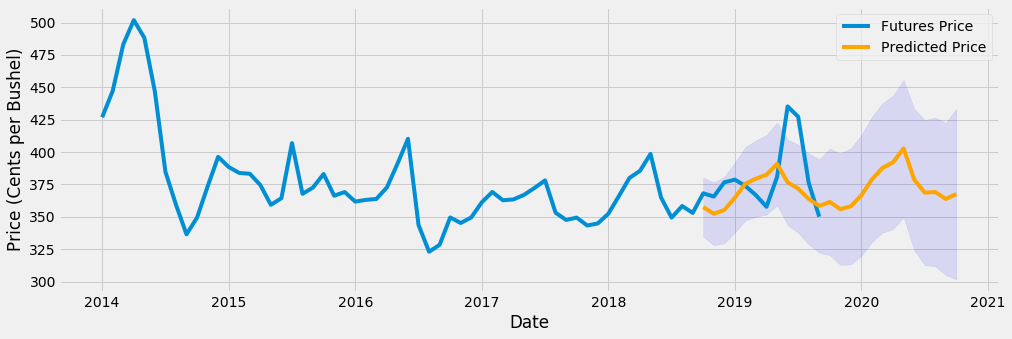

In [63]:
res_5years = sarimax_plot(corn_monthly, 
                   order=(0, 1, 1), 
                   trend='n', 
                   seasonal_order=(1, 1, 0, 12), 
                   train_delta=12, 
                   predict_delta=24,
                   start_date='2014-1-1',
                   filename='visuals/corn_monthly_5year.png',
                  )

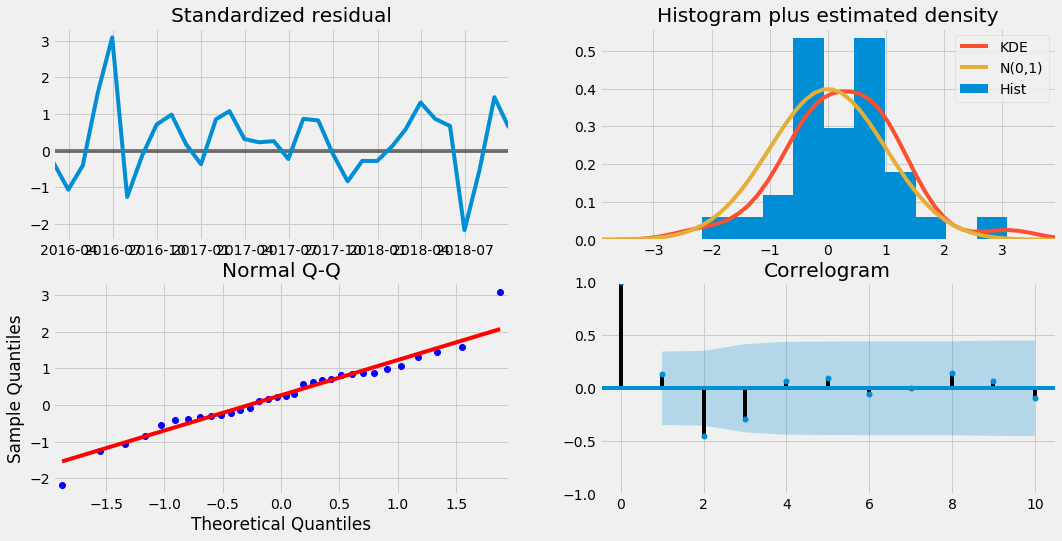

In [32]:
res_5years.plot_diagnostics(figsize=(16, 8))
plt.show()

In [53]:
prediction = res_5years.predict(res_5years.nobs, res_5years.nobs+12)

In [54]:
actual = corn_monthly[-12:]

In [55]:
    ((prediction - actual)**2).sum()

8560.533882696924

### Test 20 years of historical data for optimal PDQ.
  - ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1946

In [69]:
pdq_results = find_optimal_pdq(corn_monthly, 12)

100%|██████████| 8/8 [00:21<00:00,  2.95s/it]

Min AIC:
                                                  key          aic  \
27  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1946.7773...  1946.777329   
59  ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1946.8844...  1946.884488   
31  ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1948.4086...  1948.408652   
63  ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1948.5457...  1948.545742   
51  ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1954.5820...  1954.582065   

            mse  
27  8051.410332  
59  7621.930990  
31  7977.167828  
63  7552.799341  
51  7941.627605  
Min MSE:
                                                  key          aic  \
47  ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1957.7162...  1957.716261   
39  ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1973.1944...  1973.194425   
35  ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1971.4462...  1971.446264   
62  ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:2042.3707...  2042.370723   
23  ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1964.2564...  1964.256446   

            mse  
47  6952.06073

### Train model using 20 years of data.  
  - Results show there is a seasonal pattern when trained on past 20 years. 
  - Confidence intervals are not as usefull in our current model.
  - Improved models will account for supply, demand, and weather.

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                  225
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -982.723
Date:                            Wed, 11 Sep 2019   AIC                           1971.446
Time:                                    10:00:49   BIC                           1981.341
Sample:                                01-31-2000   HQIC                          1975.451
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9805      0.009    105.595      0.000       0.962       0.999
ma.S.L12      -1.0000      0.046   

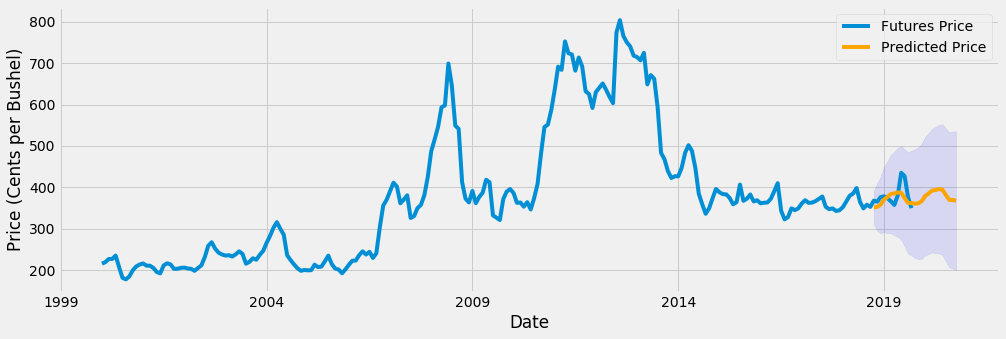

In [67]:
res = sarimax_plot(corn_monthly, 
                   order=(0, 1, 1), 
                   trend='n', 
                   seasonal_order=(0, 1, 1, 12), 
                   train_delta=12, 
                   predict_delta=24,
                   start_date=None,
                   filename='visuals/corn_monthly_20year.png',
                  )

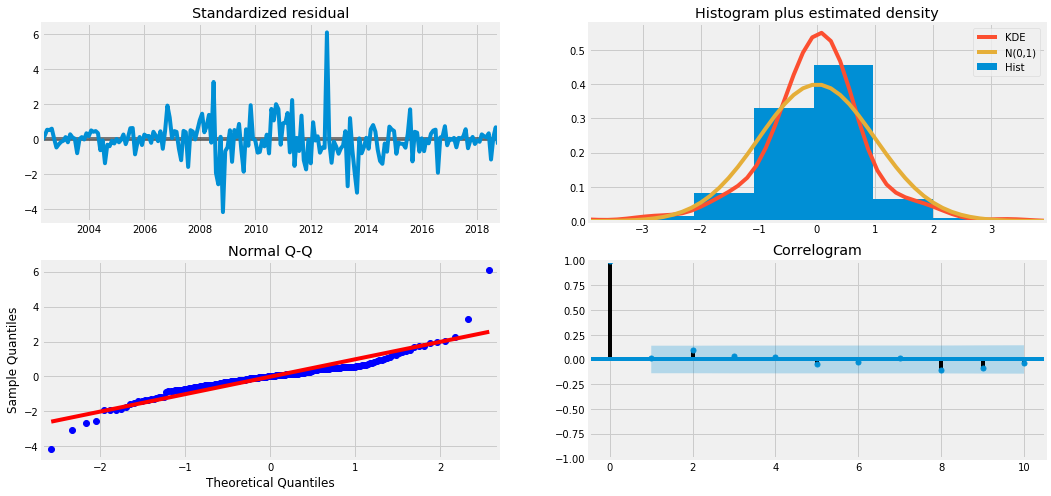

In [10]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()